### Description
   #### This mini-project is for week 4 assessment of course Introduction to Deep Learning.
   #### The dataset used in this project is the Natural Language Processing with Disaster Tweets from Kaggle.com, the link of this dataset is:<https://www.kaggle.com/competitions/nlp-getting-started/overview>
   #### The dataset contains texts of tweets inclouding keyword from the tweet, location the tweet was sent from. Note that some of them are blank. The goal of this project is to predicting whether a given tweet is about a real disaster or not. 1 incidates real and 0 indicates not real. The problem is it is not always clear whether a person's words are announcing a disaster or just using words which represent disaster in a mataphorical way.
   #### citation:  @misc{nlp-getting-started,
    author = {Addison Howard, devrishi, Phil Culliton, Yufeng Guo},
    title = {Natural Language Processing with Disaster Tweets},
    publisher = {Kaggle},
    year = {2019},
    url = {https://kaggle.com/competitions/nlp-getting-started}
}
### Github link: https://github.com/DaisyWenwenHuang/Disaster_Tweets.git

In [506]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input,Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, Conv1D,GlobalAvgPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

In [507]:
# load training dataset 
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


#### There are 7613 rows and 5 columns in this dataset.

In [508]:
# load testing dataset
df_test = pd.read_csv('test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


#### There are 3263 rows and 4 columns in the testing dataset.

## EDA

In [509]:
# take a look at the training dataframe
df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [510]:
print(f'There are {df.keyword.isnull().sum()} NaN values in keyword column.')
print(f'There are {df.location.isnull().sum()} NaN values in location column.')
print(f'There are {df.text.isnull().sum()} NaN values in text column.')

There are 61 NaN values in keyword column.
There are 2533 NaN values in location column.
There are 0 NaN values in text column.


In [511]:
# check whitespace string
def check_whitespace(txt):
    if type(txt)==str:
        if txt.isspace():
            return True
    return False

In [512]:
print(f'There are {df.keyword.apply(check_whitespace).sum()} whitespace values in keyword column.')
print(f'There are {df.location.apply(check_whitespace).sum()} whitespace values in location column.')
print(f'There are {df.text.apply(check_whitespace).sum()} whitespace values in text column.')

There are 0 whitespace values in keyword column.
There are 1 whitespace values in location column.
There are 0 whitespace values in text column.


In [513]:
# take a look at the row where has white space in location column
df[df.location.apply(check_whitespace)]

,id,keyword,location,text,target
6771,9703,tornado,,Maybe that's what happens when a tornado meets...,1


In [514]:
# replace the white place with NaN
df.iloc[6771,2]=np.NaN

0    4342
1    3271
Name: target, dtype: int64


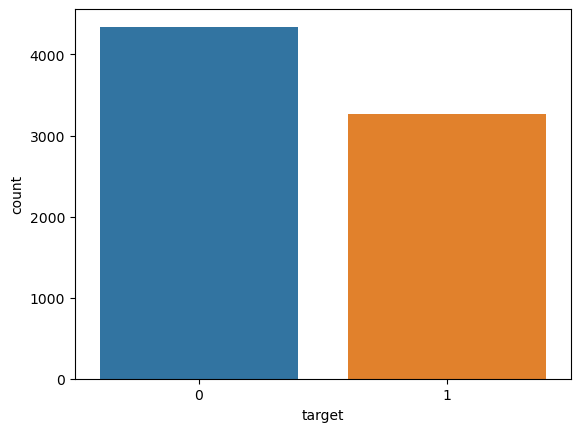

In [515]:
print(df['target'].value_counts())
sns.countplot(df,x='target');

In [516]:
4342/(4342+3271)

0.5703402075397347

#### The class is not inbalance, there is no need to do resampling. class 0(not real disaster) is 57% out of all the training tweets which means that any text classification model we create has to perform better than 57% to beat random chance.

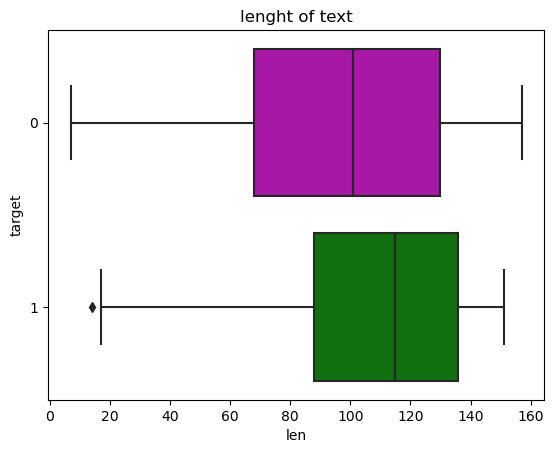

In [517]:
# take a look at the distribution of the tweet length
df['len'] = df['text'].apply(lambda x:len(x))
D=df.loc[df['target']==1]
ND=df.loc[df['target']==0]
sns.boxplot(df,y='target',x='len',palette=['m','g'],orient='h',)
plt.title('lenght of text');

In [518]:
m = D['len'].mode()[0]
m_min=D['len'].min()
m_max=D['len'].max()
nm = ND['len'].mode()[0]
nm_min=ND['len'].min()
nm_max=ND['len'].max()

In [519]:
print(f'The most common length of the Disaster tweets is: {m},\n the most common length of the non-disaster tweets is :{nm}.')
print(f'The minimum length of the Disaster tweets is: {m_min},\n the minimum length of the non-disaster tweets is :{nm_min}.')
print(f'The maximum length of the Disaster tweets is: {m_max},\n the maximum length of the non-disaster tweets is :{nm_max}.')

The most common length of the Disaster tweets is: 136,
 the most common length of the non-disaster tweets is :139.
The minimum length of the Disaster tweets is: 14,
 the minimum length of the non-disaster tweets is :7.
The maximum length of the Disaster tweets is: 151,
 the maximum length of the non-disaster tweets is :157.


#### The distribution of the length for the tweets are both left skewed and the Disaster tweets has a peak at 136 while the non-disaster tweets has a peak at 139. These statistics are before tweet text clean up including all the stopwords and punctuations.

In [520]:
df.corr(numeric_only=True)

,id,target,len
id,1.000000,0.060781,0.017393
target,0.060781,1.000000,0.181817
len,0.017393,0.181817,1.000000


##### The correlation between the target column and the length of the text column is very small that we can conclude that the length of the text has no effect on the target.

In [521]:
# create positive and negative Disaster keyword lists
Disaster=df.loc[df.target==1,'keyword'].tolist()
Disaster = [x for x in Disaster if str(x) != 'nan']
Nondisaster =df.loc[df.target==0,'keyword'].tolist()
Nondisaster = [x for x in Disaster if str(x) != 'nan']

In [522]:
def word_cloud(data,title):
    wc1=WordCloud().generate(' '.join(data))
    plt.figure(figsize=(8,6))
    plt.imshow(wc1)
    plt.axis('off')
    plt.title(title,fontsize=15)

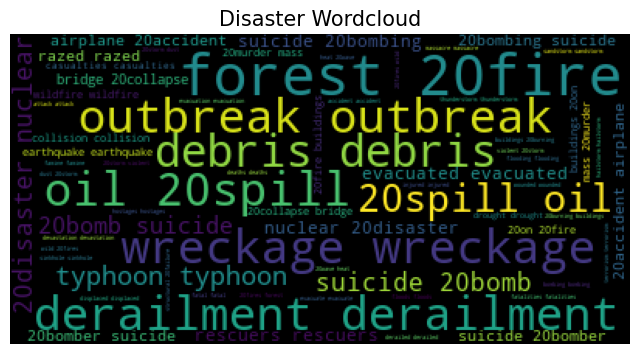

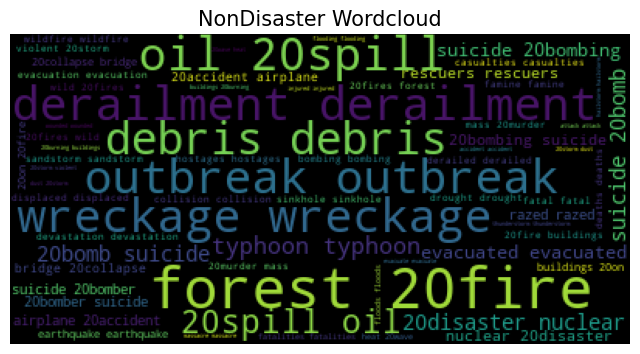

In [523]:
word_cloud(Disaster,'Disaster Wordcloud')
word_cloud(Nondisaster,'NonDisaster Wordcloud')

#### From the word clouds above, we can see that the keywords between disaster and non disaster tweets are very similar.  

In [524]:
# create positive and negative disaster location lists
Disaster=df.loc[df.target==1,'location'].tolist()
Disaster = [x for x in Disaster if str(x) != 'nan']
Nondisaster =df.loc[df.target==0,'location'].tolist()
Nondisaster = [x for x in Disaster if str(x) != 'nan']

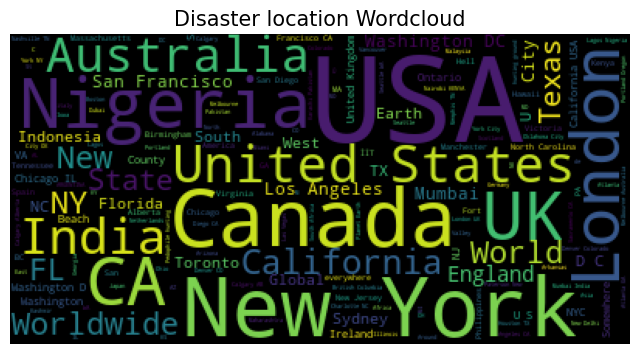

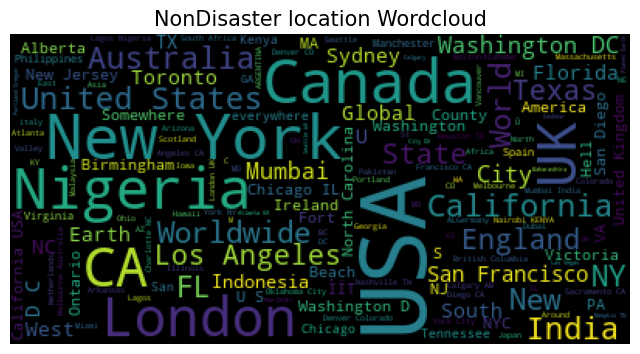

In [525]:
word_cloud(Disaster,'Disaster location Wordcloud')
word_cloud(Nondisaster,'NonDisaster location Wordcloud')

#### From the word clouds above, we can see that the location between disaster and non disaster tweets are very similar.  

## Define train tweets and test tweets

In [526]:
y = df['target'].values
X = df['text']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=401)
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((5709,), (5709,), (1904,), (1904,))

In [527]:
X_test= df_test['text']
X_test.shape

(3263,)

### Data cleaning and preprocessing

#### The dataset text column contains tweets which @ and # are speical. @ is for tagging users, # is for tagging events. In this case, @ provides information that is not relavent to the target.

In [528]:
# basic clean up of the text
# get ride of URL,non-characters,HTMLs
def cleanup_basic(txt):
    txt = txt.lower()
    txt = re.sub(r'http\S+','',txt) # remove URL
    txt = re.sub(r'@w+','',txt) # remove user name tags
    txt = re.sub(r'[^A-Za-z|\s]','',txt) # remove non-characters
    html = re.compile(r'<.*?>')
    txt = html.sub(r'',txt)  # remove html
    return txt

In [529]:
# remoave repeated characters
def cleanup_repeat(txt):
    # function to remove repeated characters due to exaggerate typing
    # eg. fine----> fiiiiiine
    txt = re.sub(r'(.)\1{3,}',r'\1',txt)
    return txt

In [530]:
# remove emoji
def cleanup_emoji(txt):
    # tweet tends to have some emojis inside
    emoji = re.compile('['
                      u'\U0001F600-\U0001F64F'
                      u'\U0001F300-\U0001F5FF'
                      u'\U0001F680-\U0001F6FF'
                      u'\U0001F1E0-\U0001F1FF'
                      u'\U00002702-\U000027B0'
                      u'\U000024C2-\U0001F251'
                      ']+',flags=re.UNICODE)
    return emoji.sub(r'',txt)

In [531]:
# separate contractions
def sep_contractions(txt):
    txt =re.sub(r"that's","that is",txt)
    txt =re.sub(r"there's","there is",txt)
    txt =re.sub(r"what's","what is",txt)
    txt =re.sub(r"where's","where is",txt)
    txt =re.sub(r"it's","it is",txt)
    txt =re.sub(r"who's","who is",txt)
    txt =re.sub(r"i'm","i am",txt)
    txt =re.sub(r"she's","she is",txt)
    txt =re.sub(r"he's","he is",txt)
    txt =re.sub(r"they're","they are",txt)
    txt =re.sub(r"who're","who are",txt)
    txt =re.sub(r"ain't","am not",txt)
    txt =re.sub(r"wouldn't","would not",txt)
    txt =re.sub(r"shouldn't","should not",txt)
    txt =re.sub(r"can't","can not",txt)
    txt =re.sub(r"couldn't","could not",txt)
    txt =re.sub(r"won't","will not",txt)
    return txt
    

In [532]:
# remove stopwords
def lemma_stopwords(txt):
    lem=WordNetLemmatizer()
    before = txt.split(' ')
    after = [lem.lemmatize(x) for x in before if x not in stopwords.words('english')]
    txt = ' '.join(after)
    return txt

In [533]:
# combined function 
def clean(txt):

    txt = txt.apply(cleanup_basic)
    txt = txt.apply(sep_contractions) 
    txt = txt.apply(cleanup_repeat)
    txt = txt.apply(cleanup_emoji)
    txt = txt.apply(lemma_stopwords)
    return txt

In [534]:
# sampel text before clean
X_train[100]

'.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad'

In [535]:
# clean text for the training data
print('Processing...')
X_train_cleaned=clean(X_train)
print('Done')

Processing...
Done


In [536]:
# sample text after clean
X_train_cleaned[100]

'norwaymfa bahrain police previously died road accident killed explosion '

In [537]:
# clean text for the validation data
print('Processing...')
X_val_cleaned=clean(X_val)
print('Done')

Processing...
Done


In [538]:
# clean text for the validation data
print('Processing...')
X_test_cleaned=clean(X_test)
print('Done')

Processing...
Done


In [539]:
# text to sequences 
max_vocab = 20000

tokenizer = Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(X_train_cleaned)
seq_train = tokenizer.texts_to_sequences(X_train_cleaned)
seq_val  = tokenizer.texts_to_sequences(X_val)

In [540]:
# test to sequences
seq_test = tokenizer.texts_to_sequences(X_test)

In [541]:
# check number of words in the voab
words2idx = tokenizer.word_index
V=len(words2idx)
V

12840

There are 12840 unique tokens.

In [542]:
# padding to NxT matrix
X_train_padded = pad_sequences(seq_train)
X_val_padded = pad_sequences(seq_val,maxlen=X_train_padded.shape[1])

print(X_train_padded.shape)
print(X_val_padded.shape)

(5709, 23)
(1904, 23)


In [543]:
# padding test data
X_test_padded = pad_sequences(seq_test,maxlen=X_train_padded.shape[1])
print(X_test_padded.shape)

(3263, 23)


### Model 1 Base model

In [544]:
# create model 1

D=10 # embedding dimension

model1 = Sequential()
model1.add(Input(shape=(X_train_padded.shape[1],)))
model1.add(Embedding(V+1,D))
model1.add(GlobalMaxPooling1D())
model1.add(Dense(1,activation='sigmoid'))


In [545]:
# model summary
model1.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_55 (Embedding)    (None, 23, 10)            128410    
                                                                 
 global_max_pooling1d_40 (G  (None, 10)                0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_58 (Dense)            (None, 1)                 11        
                                                                 
Total params: 128421 (501.64 KB)
Trainable params: 128421 (501.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Model describe
#### Model 1 has 3 layers, the embedding layer, a globalmaxpooling layer, and a output dense layer.

In [546]:
# model compile 
model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# model saving
checkpoint = ModelCheckpoint('model1.h5',monitor='val_loss',save_best_only=True)
# set an early stop to provent overfitting
early_stop = EarlyStopping(monitor='val_loss',min_delta=0.001,patience=4,mode='min',verbose=1,
                          restore_best_weights= True)
# reduce the learning rate if needed
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.3,patience=2,min_delta=0.002,
                             mode='min',verbose=1)

In [547]:
# train model1
history1 = model1.fit(X_train_padded,y_train,epochs=50,
                      validation_data=(X_val_padded,y_val),callbacks=[checkpoint,early_stop,reduce_lr])

Epoch 1/50
179/179 [==============================] - 2s 6ms/step - loss: 0.6768 - accuracy: 0.5931 - val_loss: 0.6664 - val_accuracy: 0.5888 - lr: 0.0010
Epoch 2/50
179/179 [==============================] - 1s 5ms/step - loss: 0.6297 - accuracy: 0.6935 - val_loss: 0.6343 - val_accuracy: 0.6702 - lr: 0.0010
Epoch 3/50
179/179 [==============================] - 1s 5ms/step - loss: 0.5616 - accuracy: 0.8082 - val_loss: 0.5957 - val_accuracy: 0.7342 - lr: 0.0010
Epoch 4/50
179/179 [==============================] - 1s 5ms/step - loss: 0.4879 - accuracy: 0.8494 - val_loss: 0.5643 - val_accuracy: 0.7479 - lr: 0.0010
Epoch 5/50
179/179 [==============================] - 1s 5ms/step - loss: 0.4224 - accuracy: 0.8769 - val_loss: 0.5409 - val_accuracy: 0.7589 - lr: 0.0010
Epoch 6/50
179/179 [==============================] - 1s 5ms/step - loss: 0.3682 - accuracy: 0.8917 - val_loss: 0.5252 - val_accuracy: 0.7647 - lr: 0.0010
Epoch 7/50
179/179 [==============================] - 1s 5ms/step - lo

#### Model trained for 13 epochs  with early stop.

In [548]:
def plot_his(history):
    fig,(ax0,ax1) = plt.subplots(1,2,figsize=(12,6))
    ax0.set_title('loss plot')
    ax0.plot(history.history['loss'],label='train_loss')
    ax0.plot(history.history['val_loss'],label='val_loss')
    ax0.legend()
    
    ax1.set_title('accuracy plot')
    ax1.plot(history.history['accuracy'],label='train_acc')
    ax1.plot(history.history['val_accuracy'],label='val_acc')
    ax1.legend()

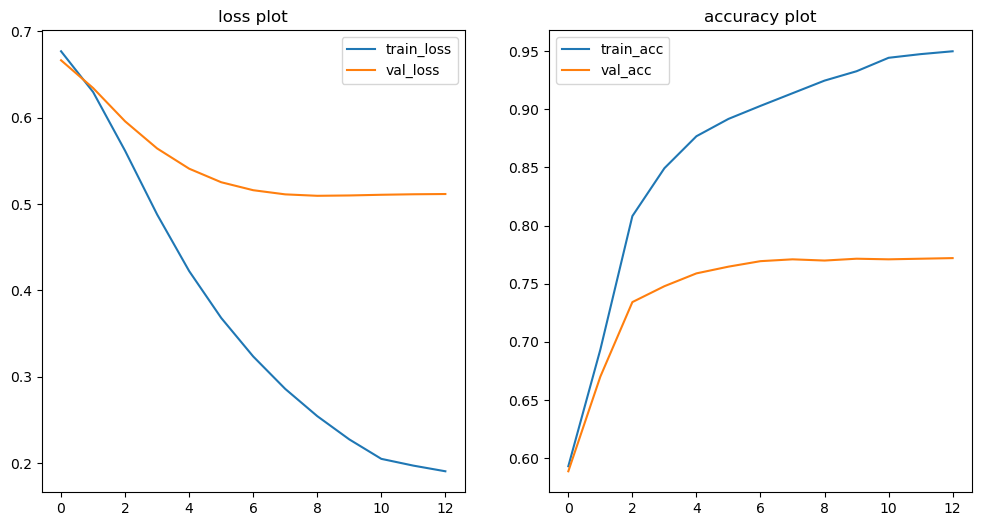

In [549]:
# plot the loss and accuracy
plot_his(history1)

### Model 2 LSTM

In [550]:
D=10
M=7

model2 = Sequential()
model2.add(Input(shape=(X_train_padded.shape[1],)))
model2.add(Embedding(V+1,D))
model2.add(LSTM(M,return_sequences=True))
model2.add(GlobalAvgPool1D())
model2.add(Dense(1,activation='sigmoid'))

In [551]:
model2.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_56 (Embedding)    (None, 23, 10)            128410    
                                                                 
 lstm_48 (LSTM)              (None, 23, 7)             504       
                                                                 
 global_average_pooling1d_8  (None, 7)                 0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_59 (Dense)            (None, 1)                 8         
                                                                 
Total params: 128922 (503.60 KB)
Trainable params: 128922 (503.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Model describe
#### Model 2 has 4 layers, the embedding layer, a LSTM layer, a global average pooling layer and a output dense layer.

In [552]:
# model compile
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# model saving
checkpoint = ModelCheckpoint('model2.h5',monitor='val_loss',save_best_only=True)

In [553]:
# train model2
history2 = model2.fit(X_train_padded,y_train,epochs=50,
                      validation_data=(X_val_padded,y_val),callbacks=[checkpoint,early_stop,reduce_lr])

Epoch 1/50
179/179 [==============================] - 7s 20ms/step - loss: 0.6794 - accuracy: 0.5666 - val_loss: 0.6587 - val_accuracy: 0.5930 - lr: 0.0010
Epoch 2/50
179/179 [==============================] - 3s 15ms/step - loss: 0.6085 - accuracy: 0.6707 - val_loss: 0.5329 - val_accuracy: 0.7726 - lr: 0.0010
Epoch 3/50
179/179 [==============================] - 3s 15ms/step - loss: 0.4653 - accuracy: 0.8301 - val_loss: 0.5073 - val_accuracy: 0.7841 - lr: 0.0010
Epoch 4/50
179/179 [==============================] - 3s 15ms/step - loss: 0.3731 - accuracy: 0.8821 - val_loss: 0.5005 - val_accuracy: 0.7894 - lr: 0.0010
Epoch 5/50
179/179 [==============================] - 3s 15ms/step - loss: 0.3023 - accuracy: 0.9136 - val_loss: 0.5290 - val_accuracy: 0.7862 - lr: 0.0010
Epoch 6/50
177/179 [============================>.] - ETA: 0s - loss: 0.2516 - accuracy: 0.9292
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
179/179 [==============================] - 3s 16

#### Model trained for 8 epochs  with early stop.

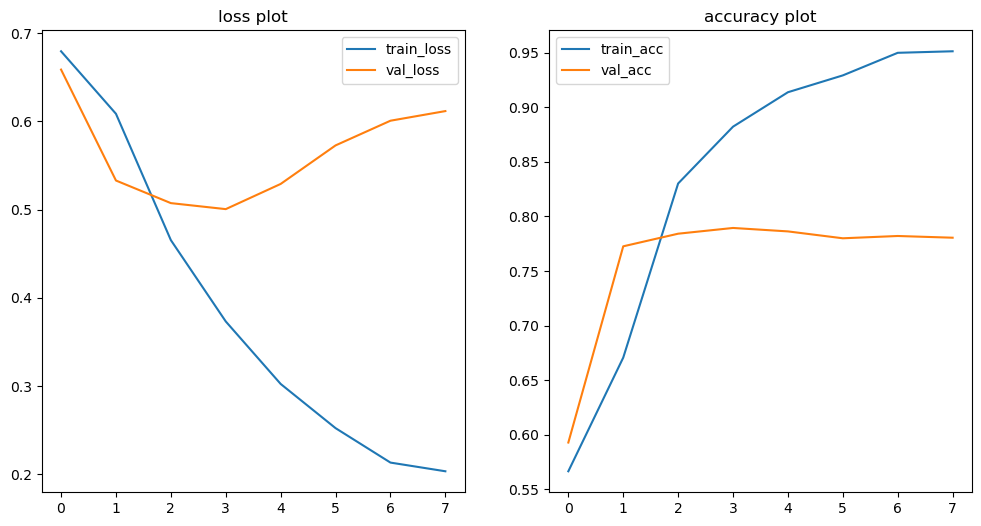

In [554]:
# plot the loss and accuracy
plot_his(history2)


#### The model is overfitted that in the loss plot, the training loss is sloping down while  the loss plot started slopping up. The accuracy of the training data is way higher than the accuracy of the validation dataset.

### Model 3

In [555]:
D=100
M=100

model3 = Sequential()
model3.add(Input(shape=(X_train_padded.shape[1],)))
model3.add(Embedding(V+1,D))
model3.add(Bidirectional(LSTM(M,dropout=0.5,return_sequences=True)))
model3.add(Dropout(0.3))
model3.add(Bidirectional(LSTM(M,dropout=0.5,return_sequences=True)))
model3.add(Dropout(0.3))
model3.add(Conv1D(100,5,activation='relu'))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(1,activation='sigmoid'))

In [556]:
model3.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_57 (Embedding)    (None, 23, 100)           1284100   
                                                                 
 bidirectional_7 (Bidirecti  (None, 23, 200)           160800    
 onal)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 23, 200)           0         
                                                                 
 bidirectional_8 (Bidirecti  (None, 23, 200)           240800    
 onal)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 23, 200)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 19, 100)         

#### Model describe
#### Model 2 has 8 layers, the embedding layer, bidirectional layer, a dropout layer with rate 0.3, birdirectional layer, a dropout layer with rate 0.3, a convolustion layer , a max pooling layer and a dense layer.

In [557]:
# model compile
model3.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# model saving
checkpoint = ModelCheckpoint('model3.h5',monitor='val_loss',save_best_only=True)

In [558]:
# train model3
history3 = model3.fit(X_train_padded,y_train,epochs=50,
                      validation_data=(X_val_padded,y_val),callbacks=[checkpoint,early_stop,reduce_lr])

Epoch 1/50
179/179 [==============================] - 58s 256ms/step - loss: 0.5585 - accuracy: 0.7147 - val_loss: 0.4984 - val_accuracy: 0.7889 - lr: 0.0010
Epoch 2/50
179/179 [==============================] - 44s 245ms/step - loss: 0.3223 - accuracy: 0.8721 - val_loss: 0.5258 - val_accuracy: 0.7631 - lr: 0.0010
Epoch 3/50
179/179 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9329
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
179/179 [==============================] - 44s 248ms/step - loss: 0.1853 - accuracy: 0.9329 - val_loss: 0.6983 - val_accuracy: 0.7432 - lr: 0.0010
Epoch 4/50
179/179 [==============================] - 44s 247ms/step - loss: 0.1007 - accuracy: 0.9651 - val_loss: 0.8402 - val_accuracy: 0.7416 - lr: 3.0000e-04
Epoch 5/50
179/179 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 0.9707Restoring model weights from the end of the best epoch: 1.

Epoch 5: ReduceLROnPlateau reducing learning rat

#### Model trained for 5 epochs  with early stop.

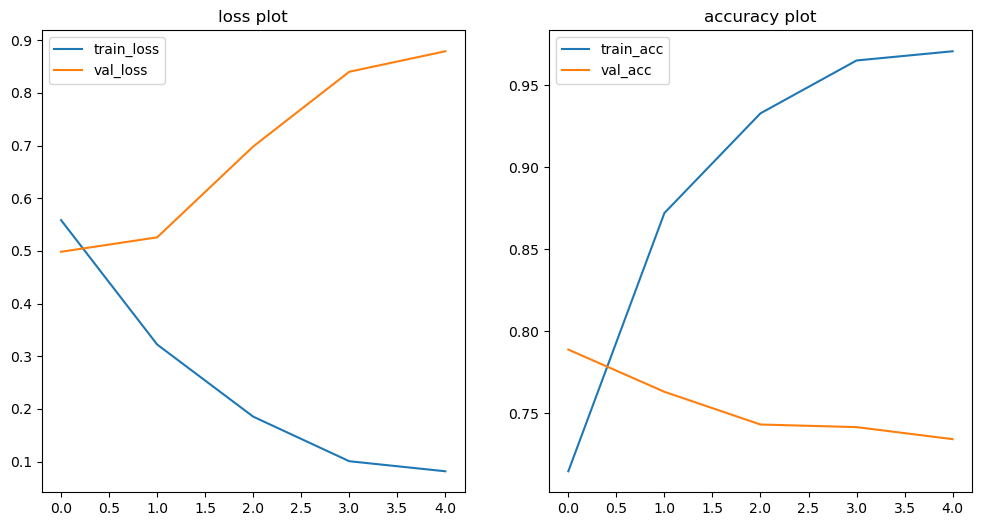

In [559]:
# plot the loss and accuracy
plot_his(history3)


### Model 4

In [560]:
model4 = Sequential()
model4.add(Input(shape=(X_train_padded.shape[1],)))
model4.add(Embedding(V+1,D))
model4.add(GlobalAvgPool1D())
model4.add(Dense(64,activation='sigmoid'))
model4.add(Dropout(0.4))
model4.add(Dense(1,activation='sigmoid'))

In [561]:
model4.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_58 (Embedding)    (None, 23, 100)           1284100   
                                                                 
 global_average_pooling1d_9  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_61 (Dense)            (None, 64)                6464      
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_62 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1290629 (4.92 MB)
Trainable params: 1290629 (4.92 MB)
Non-trainable params: 0 (0.00 Byte)
_______________

#### Model describe
#### Model 4 has 5 layers, the embedding layer, a global average pooling layer, a dense layer with 64 nodes, a drop out layer with rate of 0.4, a output dense layer 

In [562]:
# model compile
model4.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# model saving
checkpoint = ModelCheckpoint('model4.h5',monitor='val_loss',save_best_only=True)

In [563]:
# train model2
history4 = model4.fit(X_train_padded,y_train,epochs=50,
                      validation_data=(X_val_padded,y_val),callbacks=[checkpoint,early_stop,reduce_lr])

Epoch 1/50
179/179 [==============================] - 6s 27ms/step - loss: 0.7134 - accuracy: 0.5434 - val_loss: 0.6350 - val_accuracy: 0.6576 - lr: 0.0010
Epoch 2/50
179/179 [==============================] - 5s 27ms/step - loss: 0.5732 - accuracy: 0.7122 - val_loss: 0.5045 - val_accuracy: 0.7868 - lr: 0.0010
Epoch 3/50
179/179 [==============================] - 5s 27ms/step - loss: 0.3988 - accuracy: 0.8390 - val_loss: 0.4658 - val_accuracy: 0.7941 - lr: 0.0010
Epoch 4/50
179/179 [==============================] - 5s 27ms/step - loss: 0.2929 - accuracy: 0.8891 - val_loss: 0.4910 - val_accuracy: 0.7946 - lr: 0.0010
Epoch 5/50
178/179 [============================>.] - ETA: 0s - loss: 0.2238 - accuracy: 0.9180
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
179/179 [==============================] - 4s 25ms/step - loss: 0.2242 - accuracy: 0.9177 - val_loss: 0.5371 - val_accuracy: 0.7799 - lr: 0.0010
Epoch 6/50
179/179 [==============================] - 5s 27

#### Model trained for 7 epochs  with early stop.

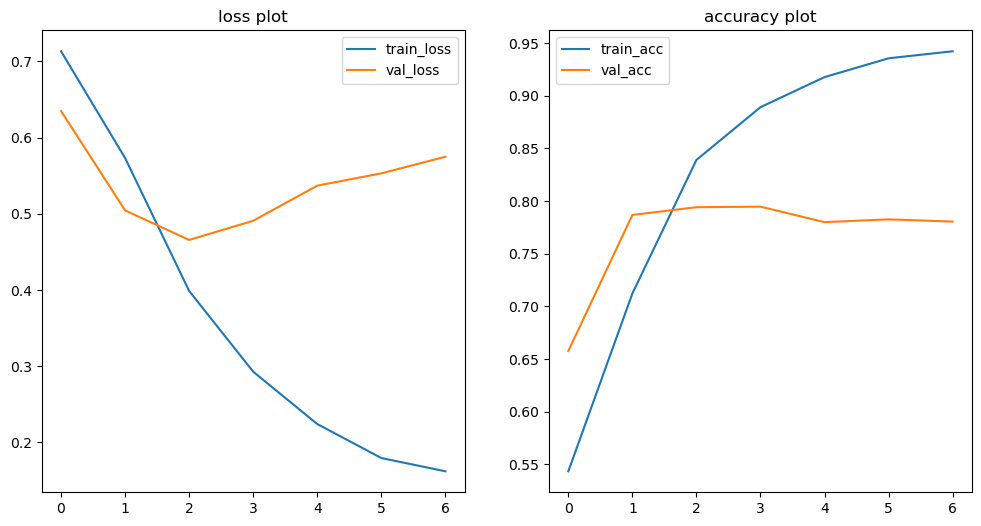

In [564]:
# plot the loss and accuracy
plot_his(history4)


In [565]:
# prediction of test data
predictions_val1 = tf.math.round(model1.predict(X_val_padded)).numpy().astype(int)
predictions_val2 = tf.math.round(model2.predict(X_val_padded)).numpy().astype(int)
predictions_val3 = tf.math.round(model3.predict(X_val_padded)).numpy().astype(int)
predictions_val4 = tf.math.round(model4.predict(X_val_padded)).numpy().astype(int)


60/60 [==============================] - 0s 2ms/step


In [566]:
def results(y_val,y_pred):
    # confusion matrix
    print(confusion_matrix(y_val,predictions_val1))
    print(classification_report(y_val,predictions_val1))
    # Print the overall accuracy
    print(accuracy_score(y_val,predictions_val1))

In [567]:
# results of model 1
results(y_val,predictions_val1)

[[1005  102]
 [ 336  461]]
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1107
           1       0.82      0.58      0.68       797

    accuracy                           0.77      1904
   macro avg       0.78      0.74      0.75      1904
weighted avg       0.78      0.77      0.76      1904

0.7699579831932774


In [568]:
# results of model 2
results(y_val,predictions_val2)

[[1005  102]
 [ 336  461]]
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1107
           1       0.82      0.58      0.68       797

    accuracy                           0.77      1904
   macro avg       0.78      0.74      0.75      1904
weighted avg       0.78      0.77      0.76      1904

0.7699579831932774


In [569]:
# results of model 3
results(y_val,predictions_val3)

[[1005  102]
 [ 336  461]]
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1107
           1       0.82      0.58      0.68       797

    accuracy                           0.77      1904
   macro avg       0.78      0.74      0.75      1904
weighted avg       0.78      0.77      0.76      1904

0.7699579831932774


In [570]:
# results of model 4
results(y_val,predictions_val4)

[[1005  102]
 [ 336  461]]
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1107
           1       0.82      0.58      0.68       797

    accuracy                           0.77      1904
   macro avg       0.78      0.74      0.75      1904
weighted avg       0.78      0.77      0.76      1904

0.7699579831932774


The four modles has same accuracy.

In [571]:
# testing data with all 4 models
predictions_test1 = tf.math.round(model1.predict(X_test_padded)).numpy().astype(int)
predictions_test2 = tf.math.round(model2.predict(X_test_padded)).numpy().astype(int)
predictions_test3 = tf.math.round(model3.predict(X_test_padded)).numpy().astype(int)
predictions_test4 = tf.math.round(model4.predict(X_test_padded)).numpy().astype(int)

102/102 [==============================] - 0s 2ms/step


In [572]:
df_test['target1']=predictions_test1
df_test['target2']=predictions_test2
df_test['target3']=predictions_test3
df_test['target4']=predictions_test4

In [573]:
df_test.head(5)

,id,keyword,location,text,target1,target2,target3,target4
0,0,NaN,NaN,Just happened a terrible car crash,1,0,1,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1,0,0,0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1,1,1,1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0,0,0,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1,1,1,1


In [574]:
submission = df_test[['id','target1']]
submission1 = df_test[['id','target2']]
submission2 = df_test[['id','target3']]
submission3 = df_test[['id','target4']]

In [575]:
submission.to_csv('submission.csv',index=False)
submission.to_csv('submission1.csv',index=False)
submission.to_csv('submission2.csv',index=False)
submission.to_csv('submission3.csv',index=False)

## Conclusion and Disscussion
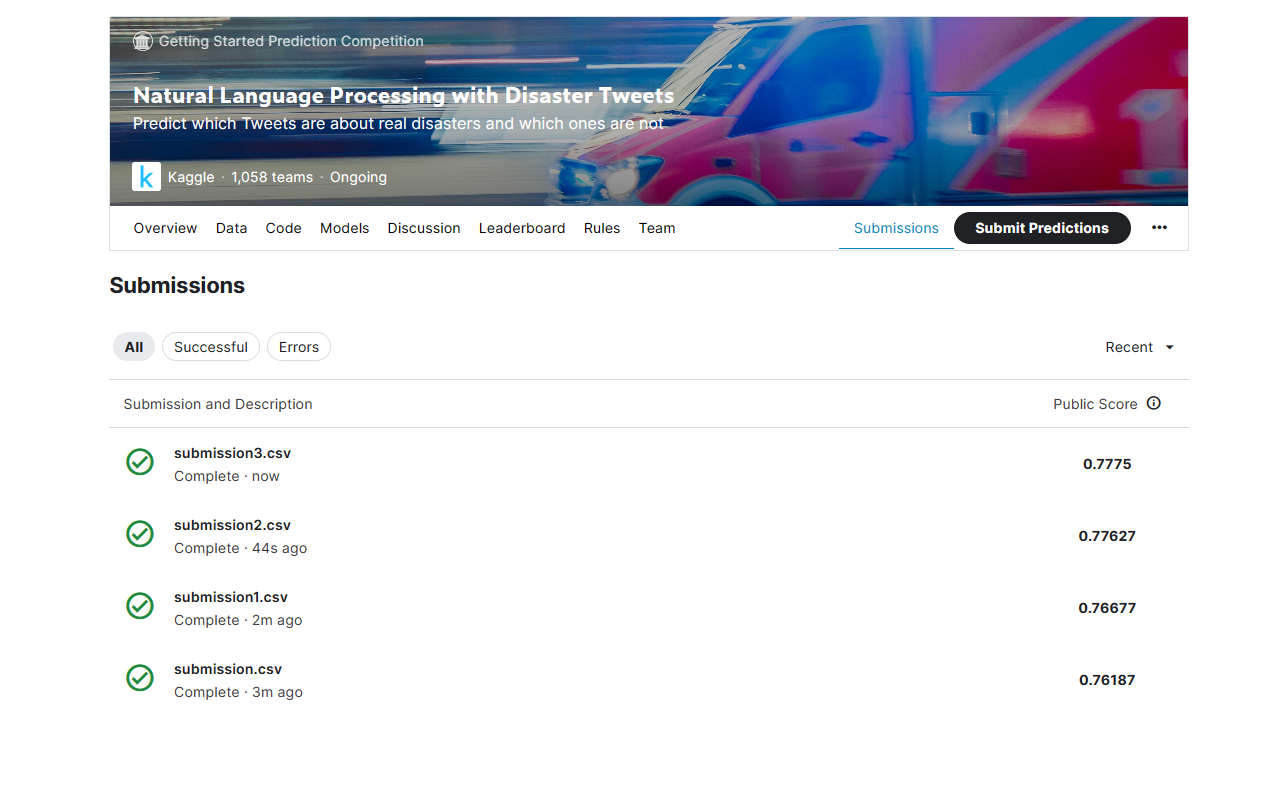
All 4 models have similar accuracy, around 0.77. Model 4 is slightly better than other models.